## **PROCESANDO LOS LOGS DE MOODLE**

### **Dependencias**

In [1]:
import requests
import json
import pandas as pd
import numpy as np

from os import getenv, getcwd
from dotenv import load_dotenv
from itertools import groupby
from threading import Thread
import altair as alt
import redis
import datetime
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from boruta import BorutaPy

load_dotenv()

MOODLE_TOKEN = getenv("MOODLE_TOKEN_OLD")
MOODLE_URL = getenv("MOODLE_URL_OLD")
# MOODLE_TOKEN ="d7786599910d2baa4c3358cda322aeaa"
# MOODLE_URL = "https://eva-pre4.umet.edu.ec/webservice/rest/server.php"
FILES_PATH = "../data/"

In [2]:
print(MOODLE_TOKEN)

a0f999eaef3b50075495fd54a95ea3ef


In [2]:
logs_file = pd.read_excel(FILES_PATH + "BDLogs_20230705-2-Abril hasta 1-Julio.xlsx")

In [3]:
logs_view_file = pd.read_excel(FILES_PATH + "OJOJOJOLogs_Views.xlsx")

In [4]:
with open(FILES_PATH + "courses_splitted_withAllGrades.json") as file:
    courses_with_grades = json.load(file)
    file.close()

In [5]:
with open(FILES_PATH + "CourseContents_61_27_11.json") as file:
    course_content = json.load(file)
    file.close()

In [5]:
#obtener estudiantes a analizar 
def get_regular_students():
    current_students = []
    for courseID in courses_with_grades.keys():
        current_students.extend(courses_with_grades[courseID]["final_grades"].keys())

    return set(current_students)


In [7]:
#procesamiento de los logs de moodle
def process_logs_files(logs_file, filter_by_student = True):
    data = logs_file
    data["ID_USUARIO"] = logs_file["Descripción"].str.extract('[i][d]\s\'(\d*|-1)\'', expand=True)
    data["ID_RECURSO"] = logs_file["Descripción"].str.extract('(with course module id|course module with id)\s\'(\d*)\'',
                                                                        expand=True)[1]
    data["ID_CURSO"] = logs_file["Descripción"].str.extract('(course with id|course with the id)\s\'(\d*)\'',
                                                                        expand=True)[1]
    data = data.fillna("-")
    coursesID = []
    with open(FILES_PATH + "moduleIndexes.json") as file:
        modules_json = json.load(file)
        file.close()

    
    # for i in data.index:
    #     try:
    #         data["ID_CURSO"][i] = str(modules_json[str(data["ID_RECURSO"][i])]["courseID"])
    #     except:
    #         continue

    for resourceID in data["ID_RECURSO"]:
        try:
            coursesID.append(str(modules_json[str(resourceID)]["courseID"]))
        except KeyError:
            coursesID.append("-")

    data["ID_CURSO"] = coursesID
    course_filter = data["ID_CURSO"].isin(courses_with_grades.keys())
    data = data[course_filter]
    print(len(data["ID_CURSO"]))
    if filter_by_student:
        current_students = get_regular_students()
        user_filter = data["ID_USUARIO"].isin(current_students)
        data_filtered = data[user_filter]
        return data_filtered
    
    return data

### **Procesar Datos**

In [8]:
data = process_logs_files(logs_file)


121680


In [9]:
def GetUserID(cedula):
    params = {
        'wstoken': MOODLE_TOKEN, 
        'moodlewsrestformat' : 'json',
        'wsfunction' : 'core_user_get_users',
        'criteria[0][key]' : 'username', 
        'criteria[0][value]' : cedula 
    }
    r =  requests.get(MOODLE_URL, params).json()
    try:
        result = r["users"][0]["id"]
    except:
        print(r)
        result = -1       
    return result

In [36]:
rep_df = pd.read_excel(FILES_PATH + "REPORTE_PRIMER_CORTE_2711.xlsx", sheet_name="Con profesores")

rep_df_filter = rep_df.drop_duplicates(["PROFESOR CEDULA"])

teachers = {GetUserID(x) : x for x in rep_df_filter["PROFESOR CEDULA"]}

print(teachers)

{'users': [], 'warnings': []}
{'users': [], 'warnings': []}


KeyboardInterrupt: 

In [9]:
def process_datetime(datetime_str : str):
    date, time = datetime_str.split(", ")
    date = [int(x) for x in date.split("/")]
    date.reverse()
    #date = datetime.date(*date)
    time = datetime.time.fromisoformat(time)
    return  datetime.datetime(*date, time.hour, time.minute, time.second)

In [11]:
user_filter = data["ID_USUARIO"].isin(set([str(x) for x in teachers.keys()]))
data = data[user_filter]


NameError: name 'teachers' is not defined

In [10]:
weeks ={
"semana 1" : [datetime.datetime(23, 10, 23), datetime.datetime(23, 10, 29, 23,59,00)],
"semana 2" : [datetime.datetime(23, 10, 30), datetime.datetime(23, 11, 5, 23,59,00)],
"semana 3" : [datetime.datetime(23, 11, 6), datetime.datetime(23, 11, 12, 23,59,00)],
"semana 4" : [datetime.datetime(23, 11, 13), datetime.datetime(23, 11, 19, 23,59,00)],
"semana 5" : [datetime.datetime(23, 11, 20), datetime.datetime(23, 11, 26, 23,59,00)]
}
def get_week(datetime_str):
    date_time = process_datetime(datetime_str)
    for week, period in weeks.items():
        if date_time > period[0] and date_time < period[1]:
            return week
    return ""

In [12]:
def get_OFG(id_curso):
    for course in course_content: 
        if str(course["IDCurso"]) == id_curso:
            profesor = course["Docentes"].split(",")[0]
            if profesor == "-":
                return None
            result = {
                "PLATAFORMA" : course["categ_1"],
                "FACULTAD" : course["categ_3"],
                "PERIODO" : course["categ_2"],
                "CARRERA" : course["categ_4"],
                "TIPO APROBACION" : course["categ_5"],
                "PROFESOR NOMBRE" : profesor.split(":")[1],
                "PROFESOR CEDULA" : profesor.split(":")[0],
                "NOMBRE" : course["Nombre"],
                "OFG" : course["OFG"],
                "CANT_ESTUDIANTES" : course["NoEstudiantes"],
            }
            return result
    return None

In [49]:
data_grouped = data.groupby(["ID_CURSO", "ID_USUARIO"])
final_xls = []
for user, indexs in data_grouped.groups.items():
    if(user[0] == "-"):
        continue
    result = get_OFG(user[0])
    if result:
        result.update({
            "semana 1" : 0,
            "semana 2" : 0,
            "semana 3" : 0,
            "semana 4" : 0,
            "semana 5" : 0
        })
    else:
        continue
    for row in indexs:
        week = get_week(data["Hora"][row])
        if week:
            result[week] += 1
    final_xls.append(result)
    del result

excel_df = pd.json_normalize(final_xls)

final_df = []

xls_grouped = excel_df.copy().groupby("OFG").groups

for ofg, indexs in xls_grouped.items():
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0 
    for i in indexs:
        count1 += excel_df["semana 1"][i]
        count2 += excel_df["semana 2"][i]
        count3 += excel_df["semana 3"][i]
        count4 += excel_df["semana 4"][i]
        count5 += excel_df["semana 5"][i]
    row = {
        "PLATAFORMA" : excel_df["PLATAFORMA"][list(indexs)[0]],
        "FACULTAD" : excel_df["FACULTAD"][list(indexs)[0]],
        "PERIODO" : excel_df["PERIODO"][list(indexs)[0]],
        "CARRERA" : excel_df["CARRERA"][list(indexs)[0]],
        "TIPO APROBACION" : excel_df["TIPO APROBACION"][list(indexs)[0]],
        "PROFESOR NOMBRE" : excel_df["PROFESOR NOMBRE"][list(indexs)[0]],
        "PROFESOR CEDULA" : excel_df["PROFESOR CEDULA"][list(indexs)[0]],
        "NOMBRE" : excel_df["NOMBRE"][list(indexs)[0]],
        "OFG" : excel_df["OFG"][list(indexs)[0]],
        "CANT_ESTUDIANTES" : excel_df["CANT_ESTUDIANTES"][list(indexs)[0]],
        "semana 1" : count1,
        "semana 2" : count2,
        "semana 3" : count3,
        "semana 4" : count4,
        "semana 5" : count5
    }
    final_df.append(row)
    del row
    

new_df = pd.json_normalize(final_df)
with pd.ExcelWriter(FILES_PATH + "REPORTE_USO_PRIMER_CORTE_2711_ORIGINAL.xlsx") as writer:
    new_df.to_excel(writer, index = False)
    

In [11]:
data_view = process_logs_files(logs_view_file)

310290


In [12]:
all_data = pd.concat([data, data_view], join="inner", ignore_index=True)

In [16]:
#ver módulos utilizados

component_data = data.drop_duplicates(["Componente"])
print(component_data["Componente"])



0                              Tarea
1                  Archivos enviados
4                            Sistema
142                         Glosario
315        Comentarios de la entrega
473                     Cuestionario
1616                            Foro
2584                      Asistencia
3221             Tours para usuarios
3616                         Carpeta
9642      Entregas de texto en línea
31720              Bolsa de Recursos
34787                        Lección
70174                         Taller
203407                         Libro
404661                          Wiki
Name: Componente, dtype: object


In [17]:
#ver módulos vistos
component_data_view = data_view.drop_duplicates(["Componente"])
print(component_data_view["Componente"])

0                 Tarea
100             Recurso
185             Carpeta
381                Foro
420        Cuestionario
525                 URL
1077             Taller
2670           Glosario
6950      Anotación PDF
36182              Wiki
73045           Lección
94281       Mapa mental
629520         Consulta
629521             Chat
Name: Componente, dtype: object


In [13]:
#módulos a tener en cuenta
attr_1 = [("Tarea",0), ("Glosario", 0), ("Cuestionario",0), ("Foro",0), ("Carpeta",0), ("Recurso",0), ("URL", 0)]

In [14]:
attr_2 = [("assign_view", 0), ("assign_submit", 0), ("quiz_attempt", 0), ("quiz_submit", 0), ("quiz_view", 0),
            ("forum_part", 0), ("forum_view", 0), ("resource_view", 0), ("folder_view", 0), ("url_view", 0),
            ("AM+",0), ("AM-", 0), ("PM+", 0), ("PM-", 0)]

attr_2_map = {
    ("Tarea", "Módulo de curso visto") : "assign_view",
    ("Cuestionario", "Módulo de curso visto") : "quiz_view",
    ("Recurso", "Módulo de curso visto") : "resource_view",
    ("Carpeta", "Módulo de curso visto") : "folder_view",
    ("Foro", "Módulo de curso visto") : "forum_view",
    ("URL", "Módulo de curso visto") : "url_view",
    ("Foro", "Tema creado") : "forum_part",
    ("Foro", "Algún contenido ha sido publicado.") : "forum_part",
    ("Foro", "Mensaje actualizado") : "forum_part",
    ("Foro", "Mensaje creado") : "forum_part",
    ("Foro", "Suscripción activada") : "forum_part",
    ("Tarea", "Se ha enviado una entrega") : "assign_submit",
    ("Cuestionario", "Ha comenzado el intento") : "quiz_attempt",
    ("Cuestionario", "Intento enviado") : "quiz_submit",
}

### Métodos auxiliares

In [16]:
#buscar calificacion de estudiante
def find_grade(courseID, userID):
    params = {
        "wstoken" : MOODLE_TOKEN,
        "moodlewsrestformat" : "json",
        "wsfunction" : "gradereport_overview_get_course_grades",
        "userid" : int(userID)
    }
    response = requests.get(MOODLE_URL, params = params).json()
    for grade in response["grades"]:
        if grade["courseid"] == int(courseID):
            print(grade["rawgrade"])
            if grade["rawgrade"] is None:
                break
            return float(grade["rawgrade"])
    return None


In [17]:
def process_datetime(datetime_str : str):
    date, time = datetime_str.split(" ")
    date = [int(x) for x in date.split("/")]
    date.reverse()
    date = datetime.date(*date)
    time = datetime.time.fromisoformat(time)
    return date, time

In [18]:
total_days = datetime.date(2023, 7, 1) - datetime.date(2023, 4, 2)
first_day = datetime.date(2023, 4, 2)
print(total_days)
def get_tds_tda(list_index, mark):
    first_date, _ = process_datetime(all_data["Hora"][list_index[0]])
    last_date, _ = process_datetime(all_data["Hora"][list_index[0]])
    days_acces_count = 1
    for index in list_index:
        current_date, _ = process_datetime(all_data["Hora"][index])
        if current_date < first_date:
            first_date = current_date
            days_acces_count += 1
        elif current_date > last_date:
            last_date = current_date
            days_acces_count += 1
    tds = (last_date - first_date).days
    tds = tds if tds > 0 else 1
    total_days = mark - first_day
    return tds, days_acces_count, np.tanh(days_acces_count/total_days.days)


90 days, 0:00:00


In [23]:
print(datetime.timedelta())

0:00:00


In [19]:
def get_time_category(time):
    morning = datetime.time(6,00)
    midday = datetime.time(12,00)
    afternoon = datetime.time(18,00)
    evening = datetime.time.max
    if time <= morning:
        return "AM+"
    if time > morning and time <= midday:
        return "AM-"
    if time > midday and time <= afternoon:
        return "PM+"
    if time > afternoon and time <= evening:
        return "PM-"
    


### **Creando y Analizando Primer Dataset**

In [20]:
mark_25 = datetime.date(2023,4,2) + datetime.timedelta(total_days.days * 0.25)
mark_50 = datetime.date(2023,4,2) + datetime.timedelta(total_days.days * 0.50)
mark_75 = datetime.date(2023,4,2) + datetime.timedelta(total_days.days * 0.75)
mark_100 = datetime.date(2023,7,1)

In [21]:
def build_dataset1(mark = None):
    user_map_index = {}
    course_map_index = {}
    all_data_groups = all_data.groupby(["ID_CURSO", "ID_USUARIO"]).groups
    count = 0
    final_data_json = []
    problems = 0
    for group, list_index in all_data_groups.items():
        if(group[0] == "-"):
            continue
        if group[0] not in course_map_index.keys():
            course_map_index[group[0]] = []
        row = dict(attr_1)
        for index in list_index:
            try:
                currentDate, currentTime = process_datetime(all_data["Hora"][index])
                if currentDate > mark: continue
                row[all_data["Componente"][index]] += 1
            except:
                continue
            
        try:
            current_grade = courses_with_grades[group[0]]["final_grades"][group[1]]
        except KeyError:
            current_grade = find_grade(*group)
            if current_grade is None:
                problems += 1
                continue
        row["Nota"] = current_grade
        row["status"] = 1 if current_grade > 75 else 0
        user_map_index[count] = group[1]
        final_data_json.append(row)
        course_map_index[group[0]].append(count)
        count += 1
        del row
    return problems, user_map_index, course_map_index, pd.json_normalize(final_data_json)


In [24]:
problems, user_map_index, course_map_index, dataset_1 = build_dataset1(mark_100)

0.00000
0.04000
None
None
None
None
None
None
None
None
None
None
None
None
100.00000
None
None
None
None
None
100.00000
None
None
None
None
100.00000
None


In [25]:
dataset_1

,Tarea,Glosario,Cuestionario,Foro,Carpeta,Recurso,URL,Nota,status
0,103,0,32,0,17,2,0,80.100000,1
1,55,0,39,0,1,0,0,87.900000,1
2,70,1,23,0,4,0,0,35.315000,0
3,109,6,65,0,15,0,0,90.900000,1
4,79,3,26,0,2,0,0,84.563334,1
...,...,...,...,...,...,...,...,...,...
2880,121,0,23,0,18,5,0,97.364769,1
2881,62,0,10,0,1,0,0,87.423385,1
2882,85,0,17,0,8,1,0,89.417385,1
2883,79,0,15,0,7,4,0,92.055769,1


In [26]:
with pd.ExcelWriter(FILES_PATH + "Dataset1_100%.xlsx") as writer:
    dataset_1.to_excel(writer, index = False)

In [ ]:
print(len(course_map_index.keys()))
corr_df = dataset_1.corr("pearson")
corr_df.style.background_gradient(cmap="coolwarm")

172


,Tarea,Glosario,Cuestionario,Foro,Carpeta,Recurso,URL,Nota,status
Tarea,1.000000,0.077959,-0.027072,0.095802,0.159103,0.105535,0.083060,0.206169,0.090817
Glosario,0.077959,1.000000,-0.044135,-0.014757,-0.068563,-0.007688,0.117346,0.024676,0.031830
Cuestionario,-0.027072,-0.044135,1.000000,0.061370,0.245832,0.013647,0.184564,0.072772,0.043508
Foro,0.095802,-0.014757,0.061370,1.000000,0.144319,0.058370,0.050913,0.001103,0.019954
Carpeta,0.159103,-0.068563,0.245832,0.144319,1.000000,0.200012,0.144430,0.110297,0.068718
Recurso,0.105535,-0.007688,0.013647,0.058370,0.200012,1.000000,0.138477,0.048369,0.023546
URL,0.083060,0.117346,0.184564,0.050913,0.144430,0.138477,1.000000,-0.005965,-0.027468
Nota,0.206169,0.024676,0.072772,0.001103,0.110297,0.048369,-0.005965,1.000000,0.794484
status,0.090817,0.031830,0.043508,0.019954,0.068718,0.023546,-0.027468,0.794484,1.000000


#### Featuring Selection (Boruta)

In [28]:
dataset_1.to_excel("Dataset1.xlsx", index = False)
dataset_1.pop("Nota")
y = dataset_1.copy().pop("status")
X = dataset_1.copy().values


rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
rf.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

In [29]:
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

feat_selector.fit(X, y)
X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	4


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	4


In [32]:
feature_ranks = list(zip(dataset_1.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

all_features = ["Tarea", "Glosario", "Cuestionario", "Foro", "Carpeta", "Recurso", "URL"]
features_selected =["Tarea", "Cuestionario", "Carpeta"]

final_df_feat = []
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
    row = {
        "Feature" : feat[0],
        "Rank" : feat[1],
        "Keep" : feat[2]
    }
    final_df_feat.append(row)
    del row

final_df_feat = pd.json_normalize(final_df_feat)

Feature: Tarea                     Rank: 1,  Keep: True
Feature: Glosario                  Rank: 2,  Keep: False
Feature: Cuestionario              Rank: 1,  Keep: True
Feature: Foro                      Rank: 3,  Keep: False
Feature: Carpeta                   Rank: 1,  Keep: True
Feature: Recurso                   Rank: 3,  Keep: False
Feature: URL                       Rank: 5,  Keep: False
Feature: status                    Rank: 1,  Keep: True


In [33]:
final_df_feat

,Feature,Rank,Keep
0,Tarea,1,True
1,Glosario,2,False
2,Cuestionario,1,True
3,Foro,3,False
4,Carpeta,1,True
5,Recurso,3,False
6,URL,5,False
7,status,1,True


In [34]:
def build_dataset2(mark : datetime.date):
    user_map_index = {}
    course_map_index = {}
    all_data_groups = all_data.groupby(["ID_CURSO", "ID_USUARIO"]).groups
    count = 0
    final_data_json = []
    problems = 0
    for group, list_index in all_data_groups.items():
        if(group[0] == "-"):
            continue
        if group[0] not in course_map_index.keys():
            course_map_index[group[0]] = []
        row = dict(attr_2)
        for index in list_index:
            currentDate, currentTime = process_datetime(all_data["Hora"][index])
            if currentDate > mark: continue
            row[get_time_category(currentTime)] += 1
            try:
                row[attr_2_map[(all_data["Componente"][index], all_data["Nombre evento"][index])]] += 1
            except:
                continue
            
        try:
            current_grade = courses_with_grades[group[0]]["final_grades"][group[1]]
        except KeyError:
            current_grade = find_grade(*group)
            if current_grade is None:
                problems += 1
                continue
        tds, tda, ads = get_tds_tda(list_index, mark)
        row["TDS"] = tds
        row["TDA"] = tda
        row["ADS"] = ads
        row["final_grade"] = current_grade
        row["status"] = 1 if current_grade > 75 else 0
        user_map_index[count] = group[1]
        final_data_json.append(row)
        course_map_index[group[0]].append(count)
        count += 1
        del row
    return problems, user_map_index, course_map_index, pd.json_normalize(final_data_json)

2022-04-24


In [36]:
# problems_25, user_map_index_25, course_map_index_25, dataset_2_25 = build_dataset2(mark_25)
# problems_50, user_map_index_50, course_map_index_50, dataset_2_50 = build_dataset2(mark_50)
# problems_75, user_map_index_75, course_map_index_75, dataset_2_75 = build_dataset2(mark_75)
problems_100, user_map_index_100, course_map_index_100, dataset_2_100 = build_dataset2(mark_100)

0.00000
0.04000
None
None
None
None
None
None
None
None
None
None
None
None
100.00000
None
None
None
None
None
100.00000
None
None
None
None
100.00000
None


In [46]:
with pd.ExcelWriter(FILES_PATH + "Dataset2_25%.xlsx") as writer:
    dataset_2_25.to_excel(writer, index = False)
    
with pd.ExcelWriter(FILES_PATH + "Dataset2_50%.xlsx") as writer:
    dataset_2_50.to_excel(writer, index = False)

with pd.ExcelWriter(FILES_PATH + "Dataset2_75%.xlsx") as writer:
    dataset_2_75.to_excel(writer, index = False)

with pd.ExcelWriter(FILES_PATH + "Dataset2_100%.xlsx") as writer:
    dataset_2_100.to_excel(writer, index = False)

In [37]:
dataset_2_100

,assign_view,assign_submit,quiz_attempt,quiz_submit,quiz_view,forum_part,forum_view,resource_view,folder_view,url_view,AM+,AM-,PM+,PM-,TDS,TDA,ADS,final_grade,status
0,93,9,5,5,22,0,0,2,17,0,1,29,75,67,81,14,0.154313,80.100000,1
1,46,8,3,3,33,0,0,0,1,0,0,33,31,47,78,10,0.110656,87.900000,1
2,62,7,3,3,17,0,0,0,4,0,0,35,55,25,78,8,0.088656,35.315000,0
3,97,10,8,8,49,0,0,0,15,0,0,23,87,105,80,15,0.165140,90.900000,1
4,72,7,5,5,16,0,0,0,2,0,0,37,18,69,80,12,0.132549,84.563334,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,116,5,2,2,19,0,0,5,18,0,0,54,94,33,66,10,0.110656,97.364769,1
2881,58,4,2,2,6,0,0,0,1,0,0,5,11,65,52,7,0.077621,87.423385,1
2882,80,5,2,2,13,0,0,1,8,0,1,7,36,79,53,10,0.110656,89.417385,1
2883,75,4,2,2,11,0,0,4,7,0,0,25,48,44,80,9,0.099668,92.055769,1


In [ ]:
print(len(course_map_index.keys()))
corr_df = dataset_2_25.corr("pearson")
corr_df.style.background_gradient(cmap="coolwarm")

172


,assign_view,assign_submit,quiz_attempt,quiz_submit,quiz_view,forum_part,forum_view,resource_view,folder_view,url_view,AM+,AM-,PM+,PM-,TDS,TDA,ADS,final_grade,status
assign_view,1.000000,0.791445,-0.089560,-0.089638,-0.003702,0.060765,0.100519,0.106757,0.162285,0.084689,0.275107,0.532908,0.634744,0.662070,0.450732,0.645908,0.646475,0.200901,0.088197
assign_submit,0.791445,1.000000,-0.094984,-0.095211,-0.073963,0.043392,0.056759,0.076041,0.095528,0.062966,0.234253,0.439722,0.483188,0.524217,0.408193,0.664234,0.665134,0.226363,0.098634
quiz_attempt,-0.089560,-0.094984,1.000000,0.999927,0.713261,0.055949,0.043498,-0.042911,0.201553,0.165747,-0.064353,0.135794,0.094423,0.206911,0.232147,0.316674,0.317371,0.129814,0.110221
quiz_submit,-0.089638,-0.095211,0.999927,1.000000,0.712815,0.055994,0.043545,-0.042846,0.201258,0.165844,-0.064274,0.135267,0.094308,0.206964,0.232019,0.316626,0.317322,0.129683,0.110144
quiz_view,-0.003702,-0.073963,0.713261,0.712815,1.000000,0.047543,0.061069,0.026801,0.242499,0.178462,-0.037222,0.274868,0.196826,0.270079,0.215504,0.238470,0.239126,0.054481,0.024526
forum_part,0.060765,0.043392,0.055949,0.055994,0.047543,1.000000,0.724811,0.043827,0.100125,0.055588,0.007442,0.154999,0.084000,0.056244,0.072178,0.104957,0.104436,0.007420,0.025738
forum_view,0.100519,0.056759,0.043498,0.043545,0.061069,0.724811,1.000000,0.058598,0.146659,0.047366,0.014260,0.191373,0.121218,0.095194,0.099146,0.139538,0.139001,-0.000315,0.017711
resource_view,0.106757,0.076041,-0.042911,-0.042846,0.026801,0.043827,0.058598,1.000000,0.200012,0.138477,0.033521,0.194661,0.208425,0.102455,0.107777,0.176283,0.175256,0.048369,0.023546
folder_view,0.162285,0.095528,0.201553,0.201258,0.242499,0.100125,0.146659,0.200012,1.000000,0.144430,-0.034851,0.277967,0.319885,0.256031,0.264351,0.313716,0.312824,0.110297,0.068718
url_view,0.084689,0.062966,0.165747,0.165844,0.178462,0.055588,0.047366,0.138477,0.144430,1.000000,0.058589,0.131425,0.137394,0.139996,0.127396,0.119353,0.119430,-0.005965,-0.027468


In [38]:
dataset_2_100.to_excel("Dataset2.xlsx", index = False)
dataset_2_100.pop("final_grade")
y = dataset_2_100.copy().pop("status")
X = dataset_2_100.copy().values


# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
rf.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_jobs=-1)

In [39]:


# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)
X_filtered = feat_selector.transform(X)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	4
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	4
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	4
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	4
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	2
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	11
Tentative: 	1
Rejected: 	6
Itera

In [42]:
feature_ranks = list(zip(dataset_2_100.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results

all_features = ["assign_view", "assign_submit", "quiz_attempt", "quiz_submit"
                ,"quiz_view", "forum_part", "forum_view", "resource_view",
                "folder_view", "url_view", "AM+", "AM-", "PM+", "PM-", "TDS", "TDA", "ADS"]

features_selected = ["assign_view", "assign_submit", "quiz_attempt", "quiz_submit"
                    ,"quiz_view","PM+", "PM-", "TDS", "TDA", "ADS"]
final_df_feat = []
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
    row = {
        "Feature" : feat[0],
        "Rank" : feat[1],
        "Keep" : feat[2]
    }
    final_df_feat.append(row)
    del row

final_df_feat = pd.json_normalize(final_df_feat)

Feature: assign_view               Rank: 1,  Keep: True
Feature: assign_submit             Rank: 1,  Keep: True
Feature: quiz_attempt              Rank: 1,  Keep: True
Feature: quiz_submit               Rank: 1,  Keep: True
Feature: quiz_view                 Rank: 1,  Keep: True
Feature: forum_part                Rank: 8,  Keep: False
Feature: forum_view                Rank: 7,  Keep: False
Feature: resource_view             Rank: 6,  Keep: False
Feature: folder_view               Rank: 2,  Keep: False
Feature: url_view                  Rank: 5,  Keep: False
Feature: AM+                       Rank: 4,  Keep: False
Feature: AM-                       Rank: 3,  Keep: False
Feature: PM+                       Rank: 1,  Keep: True
Feature: PM-                       Rank: 1,  Keep: True
Feature: TDS                       Rank: 1,  Keep: True
Feature: TDA                       Rank: 1,  Keep: True
Feature: ADS                       Rank: 1,  Keep: True
Feature: status                    Rank: 

In [43]:
final_df_feat

,Feature,Rank,Keep
0,assign_view,1,True
1,assign_submit,1,True
2,quiz_attempt,1,True
3,quiz_submit,1,True
4,quiz_view,1,True
5,forum_part,8,False
6,forum_view,7,False
7,resource_view,6,False
8,folder_view,2,False
9,url_view,5,False


In [ ]:



#80% para entrenamiento y 20% para evaluación
train_set = dataset_2_25.iloc[:2308]
test_set  = dataset_2_25.iloc[2308:]


In [ ]:
y = train_set.copy().pop("status")
X = train_set.copy().values
ss = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
Kfold = {}
for i, (train_index, test_index) in enumerate(ss.split(X)):
    print(f"Fold {i}:")
    Kfold[i] = {
        "train" : train_index,
        "test" : test_index
    }


Fold 0:
  Train: index=[1572  254  575 ...  763  835 1653]
  Test:  index=[ 124 2307 1428 1964 1727  921  486 2069 1585 1081 1136  582 1969  792
 2234 1892  182  517 2162  775  553  793 1042 1240  512 1211  361  897
   57 1038 1933 2277  634 1864 1082  745  252  731 1842  384 1116  461
  245  727  156  195 1743  440  579  132 2285   69 1069 1759   70  569
  501 1227  562 2083  930 1815   53 2086  224 1281 2111 1726 1749   98
 2212  986 1994 2183 1878 1688 2123 1449  565 1687 1662  286 1076  916
 1376  805  557 1087  322 1451  818   10 1836 1625 2190 1535 1544 1783
  379 2006 1199  402  385  820 1555 1661    9 1824 1351  722 2041  483
 1502  581  657  735 1110 2297  654  251 1375 2295 1459  458 2241  148
 1831 2268 1226   39  620  723 1715 1343 1359 1414  536 2087 1518  991
 1901  715 1322 1538 1603 2228  878 1696 2204 1426 1273 1790 2038   27
  850  728  475  438  162 2184  135  713 1332 1643 1801  684  386  276
 1880 1217  651 1521  477 2005 1307  530  107  485 1504    1  757 2137
   

FOLD 1 >>>
accuracy : 0.803
precision : 0.821
recall : 0.965
f1 : 0.887
FOLD 2 >>>
accuracy : 0.831
precision : 0.853
recall : 0.967
f1 : 0.906
FOLD 3 >>>
accuracy : 0.818
precision : 0.830
recall : 0.976
f1 : 0.897
FOLD 4 >>>
accuracy : 0.805
precision : 0.829
recall : 0.960
f1 : 0.890
FOLD 5 >>>
accuracy : 0.816
precision : 0.831
recall : 0.971
f1 : 0.896


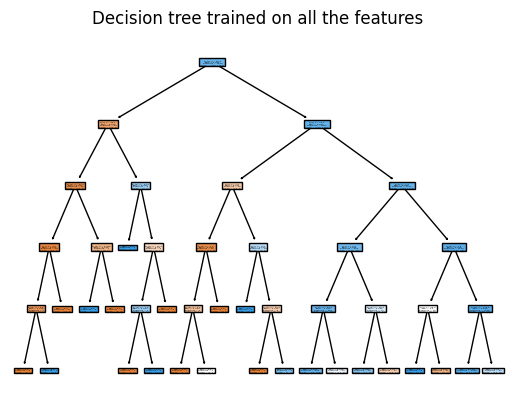

[0.1911971  0.00212165 0.03497854 0.04885961 0.10811678 0.
 0.         0.         0.         0.         0.01320137 0.01697319
 0.06166316 0.15966622 0.3316334  0.00330034 0.02828864]


In [ ]:
evaluation = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"])

for i in Kfold.keys():
    print("FOLD", i+1, ">>>")
    train = train_set.iloc[Kfold[i]["train"]]
    test = train_set.iloc[Kfold[i]["test"]]
    model = tree.DecisionTreeClassifier(max_depth=5)
    model.fit(train[all_features], train["status"])
    pred = model.predict(test[all_features])
    accuracy = accuracy_score(test["status"], pred)
    precision = precision_score(test["status"], pred)
    recall = recall_score(test["status"],pred)
    f1 = f1_score(test["status"],pred)
    print(f"accuracy : {accuracy:.3f}")
    print(f"precision : {precision:.3f}")
    print(f"recall : {recall:.3f}")
    print(f"f1 : {f1:.3f}")

import matplotlib.pyplot as plt


plt.figure()
tree.plot_tree(model, filled=True)
plt.title("Decision tree trained on all the features")
plt.show()
print(model.feature_importances_)



In [ ]:
a = [62,	7,	3,	3,	17,	0,	0,	0,	4, 0,	0,	32,	46,	18,	78,	8,	0.10]
a = [20,	3,	2,	2,	4,	0,	0,	0,	0,	0,	0,	10,	0,	21,	15,	4,	0.26]

b = np.array(a)
c = b.reshape(1,-1)
print(model.predict(c))


[1]


[Text(0.34558823529411764, 0.9166666666666666, 'x[14] <= 30.5\ngini = 0.311\nsamples = 1846\nvalue = [355, 1491]'), Text(0.11764705882352941, 0.75, 'x[0] <= 39.5\ngini = 0.325\nsamples = 44\nvalue = [35, 9]'), Text(0.058823529411764705, 0.5833333333333334, 'x[16] <= 0.128\ngini = 0.157\nsamples = 35\nvalue = [32, 3]'), Text(0.029411764705882353, 0.4166666666666667, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'), Text(0.08823529411764706, 0.4166666666666667, 'x[16] <= 0.863\ngini = 0.059\nsamples = 33\nvalue = [32, 1]'), Text(0.058823529411764705, 0.25, 'gini = 0.0\nsamples = 32\nvalue = [32, 0]'), Text(0.11764705882352941, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'), Text(0.17647058823529413, 0.5833333333333334, 'x[12] <= 24.0\ngini = 0.444\nsamples = 9\nvalue = [3, 6]'), Text(0.14705882352941177, 0.4166666666666667, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'), Text(0.20588235294117646, 0.4166666666666667, 'x[14] <= 28.0\ngini = 0.48\nsamples = 5\nvalue = [3, 2]'), Text(0.1764705882352

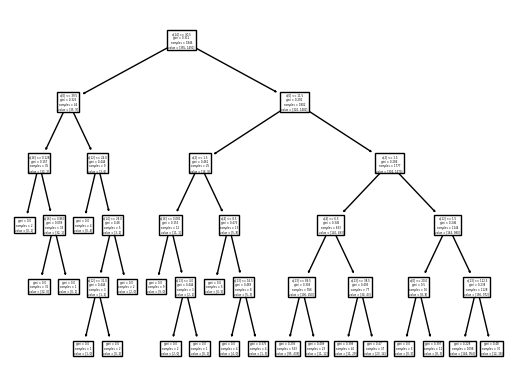

In [ ]:
print(tree.plot_tree(model))

In [ ]:
#clase para preprocesar los logs de moodle
class Raw_Data:
    def __init__(self, logs_file : str = "", logs_view_file : str = "", user_oriented_json : str = ""):
        if logs_file and logs_view_file:
            self._logs_file = pd.read_excel(FILES_PATH + logs_file)
            self._logs_view_file = pd.read_excel(FILES_PATH + logs_view_file)
            self._logs_Data = Raw_Data._preprocessLogs(self._logs_file)
            self._logs_view_Data = Raw_Data._preprocessLogs(self._logs_view_file)
            try:
                #! esto hay que cogerlo de redis
                with open(FILES_PATH + "moduleIndexes.json") as file:
                    self._module_json = json.load(file)
                    file.close()
            except Exception as e:
                raise e
            user_oriented_json = self._buildOrientedUserReportJson()
            self._add_module_views_usersOriented(user_oriented_json)
            self._raw_data = Raw_Data._build_rawData(user_oriented_json)
        elif(user_oriented_json):
            with open(user_oriented_json) as file:
                user_use_content = json.load(file)
                file.close()
            self._raw_data = Raw_Data._build_rawData(user_use_content)


    @property
    def raw_data(self):
        return self._raw_data

    def save_to_excel(self):
        self._raw_data.to_excel("RAW_DATA.xlsx", index = False)

    @staticmethod
    def _preprocessLogs(dataframe: pd.DataFrame):
        data = dataframe
        data["ID_USUARIO"] = dataframe["Descripción"].str.extract('[i][d]\s\'(\d*|-1)\'', expand=True)
        data["ID_RECURSO"] = dataframe["Descripción"].str.extract('(with course module id|course module with id)\s\'(\d*)\'',
                                                                    expand=True)[1]
        data["FECHA"] = dataframe["Hora"].str.split(" ", expand=True)[0]
        data = data.fillna("-")
        return data


    def _buildOrientedUserReportJson(self):
        final_user_json = {}
        groups = self._logs_Data.groupby(["ID_USUARIO"])
        groups_dict = groups.groups
        for user_id in groups_dict.keys():
            if user_id == "-1" or user_id == "-": 
                continue
            final_user_json[user_id] = {}
            for index in groups_dict[user_id]:
                name = final_user_json[user_id].setdefault("name", self._logs_Data["Nombre completo del usuario"][index])
                moduleid = self._logs_Data["ID_RECURSO"][index]
                if (moduleid == "-"):
                    continue 
                try: 
                    courseID = self._module_json[moduleid]["courseID"]       
                except KeyError:
                    continue
                course = final_user_json[user_id].setdefault(courseID, {}) 
                module = course.setdefault(moduleid, {})     
                module_name = course[moduleid].setdefault("name", self._logs_Data["Contexto del evento"][index])
                module[self._logs_Data["Hora"][index]] = self._logs_Data["Nombre evento"][index]
        return final_user_json
    
    def _add_module_views_usersOriented(self, userOriented_json : dict):
        groups = self._logs_view_Data.groupby(["FECHA", "ID_RECURSO", "ID_USUARIO"])
        groups_dict = groups.groups
        for tup in groups_dict.keys():
            fecha, moduleID, userID = tup 
            if moduleID == "-" or userID == "-1":
                continue
            try:
                courseID = self._module_json[moduleID]["courseID"]
                user = userOriented_json.setdefault(userID, {})
                name  = user.setdefault("name", self._logs_view_Data["Nombre completo del usuario"][groups_dict[tup][0]])
                course = user.setdefault(courseID, {})
                module = course.setdefault(moduleID, {})
                module_name = module.setdefault("name", self._logs_view_Data["Contexto del evento"][groups_dict[tup][0]])
                module[f"{fecha} views"] = len(groups_dict[tup])                  
            except Exception as e:
                continue


    @staticmethod
    def _build_courseID_Data():
        #! esto hay que cogerlo de redis
        with open("courseContent.json") as file:
            courseContent = json.load(file)

        keys =  ["Nombre", "OFG", "categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6", "categ_7", "IDCurso"]
        final_data = {}
        for i in range(len(courseContent)):
            tipo_aprobacion = courseContent[i]["categ_5"] + "-" + courseContent[i]["categ_6"] if courseContent[i]["categ_6"] != "-" else courseContent[i]["categ_5"]
            tipo_aprobacion = tipo_aprobacion + courseContent[i]["categ_7"] if courseContent[i]["categ_7"] != "-" else tipo_aprobacion

            try:
                final_data[courseContent[i]["IDCurso"]] = {
                    "CURSO_ID" : courseContent[i]["IDCurso"],
                    "PLATAFORMA" : courseContent[i]["categ_1"],
                    "PERIODO" : courseContent[i]["categ_2"],
                    "FACULTAD" : courseContent[i]["categ_3"],
                    "CARRERA" : courseContent[i]["categ_4"],
                    "OFG" : courseContent[i]["OFG"],
                    "TIPO APROBACION" : tipo_aprobacion,
                    "NOMBRE_CURSO" : courseContent[i]["Nombre"],
                }
            except KeyError:
                continue
        return final_data  
    
    @staticmethod
    def _build_rawData(data: dict):
        course_data = Raw_Data._build_courseID_Data()
        final_excel = []
        for user_id in data.keys():
            if user_id == "-":
                continue
            for course_id in data[user_id].keys():
                if course_id == "name":
                    continue
                for module_id in data[user_id][course_id].keys():
                    for fecha_hora in data[user_id][course_id][module_id].keys():
                        if fecha_hora == "name": continue
                        fecha = fecha_hora.split(" ")
                        if len(fecha) == 1:
                            fecha = fecha_hora.split(":")
                            if fecha[1] == "grade_status":
                                continue
                        try:
                            course = course_data[course_id]
                        except KeyError:
                            course = course_data[int(course_id)]
                        grades_views = {
                            "views" : "VISTA",
                            "grade" : "EVALUADO"
                        }
                        row = {
                            "USER_ID": user_id,
                            "USER_NOMBRE" : data[user_id]["name"] if "name" in data[user_id].keys() else "-",
                            "CURSO_ID" : course_id,
                            "PLATAFORMA" : course["PLATAFORMA"],
                            "PERIODO" : course["PERIODO"],
                            "FACULTAD" : course["FACULTAD"],
                            "CARRERA" : course["CARRERA"],
                            "OFG" : course["OFG"],
                            "TIPO APROBACION" : course["TIPO APROBACION"],
                            "NOMBRE_CURSO" : course["NOMBRE_CURSO"],
                            "MODULE_ID" : module_id,
                            "MODULE_NOMBRE" : data[user_id][course_id][module_id]["name"] if "name" in data[user_id][course_id][module_id].keys() else "-",
                            "FECHA" : fecha[0],
                            "EVENTO" : grades_views[fecha[1]] if fecha[1] in grades_views.keys() else data[user_id][course_id][module_id][fecha_hora],
                            "VISTAS" : data[user_id][course_id][module_id][fecha_hora] if fecha[1] == "views" else "-"
                        }
                        final_excel.append(row)
                        del row
        
        return pd.json_normalize(final_excel)